# 高斯分布下的运动预测

In [1]:
# namedtuple 
from collections import namedtuple
gaussian = namedtuple("Gaussian", ['mean', 'var'])
gaussian.__repr__ = lambda s: f'𝒩(μ={s[0]:.3f}, 𝜎²={s[1]:.3f})'

In [2]:
g1 = gaussian(3.4, 10.1)
g2 = gaussian(mean = 4.5, var = 0.2**2)

print(g1)
print(g2)

g1[0] , g1.mean, g1[1], g1.var

𝒩(μ=3.400, 𝜎²=10.100)
𝒩(μ=4.500, 𝜎²=0.040)


(3.4, 3.4, 10.1, 10.1)

In [3]:
def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)


In [4]:
pos = gaussian(10., 0.2**2)
move = gaussian(15., 0.7**2)
predict(pos, move)

𝒩(μ=25.000, 𝜎²=0.530)

# 高斯分布下的观测

In [5]:
def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)

def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior


predicted_pos = gaussian(10.0, 0.2**2)
measured_pos = gaussian(11.0, 0.1**2)

estimated_pos = update(predicted_pos, measured_pos)

print(predicted_pos)
print(measured_pos)
print(estimated_pos)

𝒩(μ=10.000, 𝜎²=0.040)
𝒩(μ=11.000, 𝜎²=0.010)
𝒩(μ=10.800, 𝜎²=0.008)


# 第一个卡尔曼滤波

In [6]:
import numpy as np

from numpy.random import randn

from math import sqrt

import matplotlib.pyplot as plt


def print_result(predict, update, z, epoch):

    # 细节暂不需要深究

    # predicted_pos, updated_posclear, measured_pos

    predict_template = '{:3.0f} {: 7.3f} {: 8.3f}'

    update_template  = '\t{: .3f}\t{: 7.3f} {: 7.3f}'

    print(predict_template.format(epoch, predict[0], predict[1]),end='\t')

    print(update_template.format(z, update[0], update[1]))


def plot_result(epochs ,prior_list, x_list, z_list):

    epoch_list = np.arange(epochs)

    plt.plot(epoch_list, prior_list, linestyle=':', color='r',label = "prior/predicted_pos", lw=2)

    plt.plot(epoch_list, x_list, linestyle='-', color='g', label = "posterior/updated_pos",lw=2)

    plt.plot(epoch_list, z_list, linestyle=':', color='b', label = "likelihood/measurement", lw=2)

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [7]:
# np.random.seed(11)

# 1. 一些初始的状态和变量的赋值
motion_var   = 15.0 # 人的运动方差
sensor_var   = 20.0 # GPS的观测方差
x            = gaussian(0, 20.**2) # 人的初始位置。因为一开始初始位置很不确认，所以方差给的很大
velocity     = 1.0
dt           = 1   # 时间单位的最小刻度
motion_model = gaussian(velocity, motion_var)

# 2. 生成数据
zs = []
current_x = x.mean
for _ in range(10): # 我们让小明走10s，每走1s就看看GPS，并且把这些数据存起来
    # 2.1 生成运动数据
    v        = velocity  + randn() * motion_var # 每秒（每个时间单位）走多少（有误差）
    current_x += v*dt # 将这一秒的位移加上到上一秒的位置 

    # 2.2 生成观测数据
    measurement = current_x + randn() * sensor_var # GPS对位置的观测（测量）也有误差
    zs.append(measurement)

epoch	PREDICT			UPDATE
     	x      var		  z	    x      var
  0   1.000  415.000		-29.057	-27.675  19.080
  1 -26.675   34.080		 8.786	 -4.328  12.604
  2  -3.328   27.604		 12.299	  5.734  11.597
  3   6.734   26.597		 24.256	 16.736  11.416
  4  17.736   26.416		-11.114	  1.317  11.382
  5   2.317   26.382		 20.700	 12.773  11.376
  6  13.773   26.376		 30.684	 23.391  11.375
  7  24.391   26.375		 28.979	 27.000  11.375
  8  28.000   26.375		 74.157	 54.251  11.375
  9  55.251   26.375		 42.244	 47.854  11.375

final estimate:                               47.854
actual final estimate:                        76.356


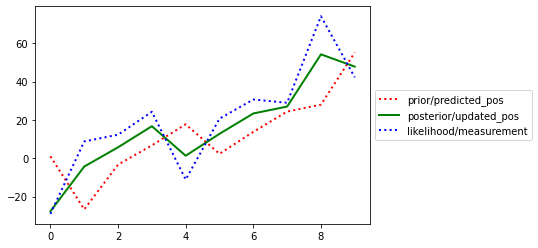

In [8]:
prior_list, x_list, z_list = [], [], []

print('epoch\tPREDICT\t\t\tUPDATE')

print('     \tx      var\t\t  z\t    x      var')

for epoch, z in enumerate(zs):
    prior = predict(x, motion_model) # 运动预测 # 两个高斯的和
    likelihood = gaussian(z, sensor_var)
    
    x = update(likelihood, prior)    # 结合观测 # 两个高斯的交集

    print_result(prior, x, z, epoch)
    prior_list.append(prior.mean)
    x_list.append(x.mean)
    z_list.append(z)


print()
print(f"final estimate:       {x.mean:30.3f}")
print(f"actual final estimate:{current_x:30.3f}")

plot_result(10, prior_list, x_list, z_list)




# 卡尔曼增益形式下的 predict 和 update

In [9]:
def predict(posterior, movement):
    # 上一轮的posterior 就是这一轮的一个predict前的位置分布
    x, P  = posterior
    dx, Q = movement # 一定时间内的位移

    # prediction
    x = x + dx  # 高斯之和， mean 相加 ，var相加
    P = P + Q

    return gaussian(x, P)

def update(measurement, prior):
    x, P = prior
    z, R = measurement

    y = z - x
    K = P / (P + R)

    x = x + K * y   # 理解
    P = (1 - K) * P # 知道

    return gaussian(x, P)



# 多元高斯下的卡尔曼滤波


In [10]:

from filterpy.common import Q_discrete_white_noise
from kf_book.mkf_internal import plot_all
import math
from scipy.linalg import inv


def compute_person_data(z_var, process_var, count=1, dt=1.):

    "returns track, measurements 1D ndarrays"

    x, vel = 0., 1.

    z_std = math.sqrt(z_var) 

    p_std = math.sqrt(process_var)

    xs, zs = [], []

    for _ in range(count):

        v = vel + (randn() * p_std)

        x += v*dt        

        xs.append(x)

        zs.append(x + randn() * z_std)        

    return np.array(xs), np.array(zs)




dt = 1.       # 单位时间刻度

R_var = 20   # 测量误差的方差 # 生产设备后，进行实验测量而得

Q_var = 0.1

x = np.array([[10.0, 4.5]]).T

P = np.diag([500, 49])

F = np.array([[1, dt],

              [0,  1]])

H = np.array([[1., 0.]])

R = np.array([[R_var]])

Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_var) # ???

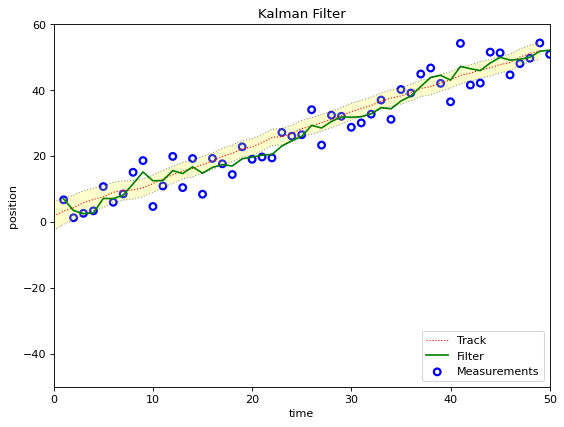

In [11]:


count = 50

track, zs = compute_person_data(R_var, Q_var, count)

xs, cov = [], []

for z in zs:
    # predict

    x = F @ x

    P = F @ P @ F.T + Q
    
    #update

    S = H @ P @ H.T + R

    K = P @ H.T @ inv(S)

    y = z - H @ x

    x += K @ y

    P = P - K @ H @ P
    

    xs.append(x)

    cov.append(P)


xs, cov = np.array(xs), np.array(cov)

from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plot_all(xs[:, 0], track, zs, cov, plot_P=False)